In [1]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *

## **Event definition**

In [ ]:
cpc = xr.open_mfdataset("../../Data/cpc/tmax.*.nc").sel(lon = slice(60,150), lat = slice(60,5)).tmax
cpc = cpc.sel(time = [m == 4 for m in cpc.time.dt.month])
cpc.to_netcdf("data/cpc_tmax_april.nc")

In [11]:
print("DONE")

DONE


In [13]:
xr.open_dataset("data/cpc_tmax_april.nc").tmax

<xarray.DataArray 'tmax' (time: 1338, lat: 110, lon: 180)>
[26492400 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 59.75 59.25 58.75 58.25 57.75 ... 6.75 6.25 5.75 5.25
  * lon      (lon) float32 60.25 60.75 61.25 61.75 ... 148.2 148.8 149.2 149.8
  * time     (time) datetime64[ns] 1979-04-01 1979-04-02 ... 2023-04-18
Attributes: (12/13)
    level_desc:    Surface
    parent_stat:   Other
    long_name:     Daily Maximum Temperature
    cell_methods:  time: mean
    valid_range:   [-90.  50.]
    avg_period:    0000-00-01 00:00:00
    ...            ...
    comments:      GTS data and is gridded using the Shepard Algorithm
    max_period:    6z to 6z
    actual_range:  [-59.656933  22.819536]
    units:         degC
    var_desc:      Maximum Temperature
    statistic:     Maximum

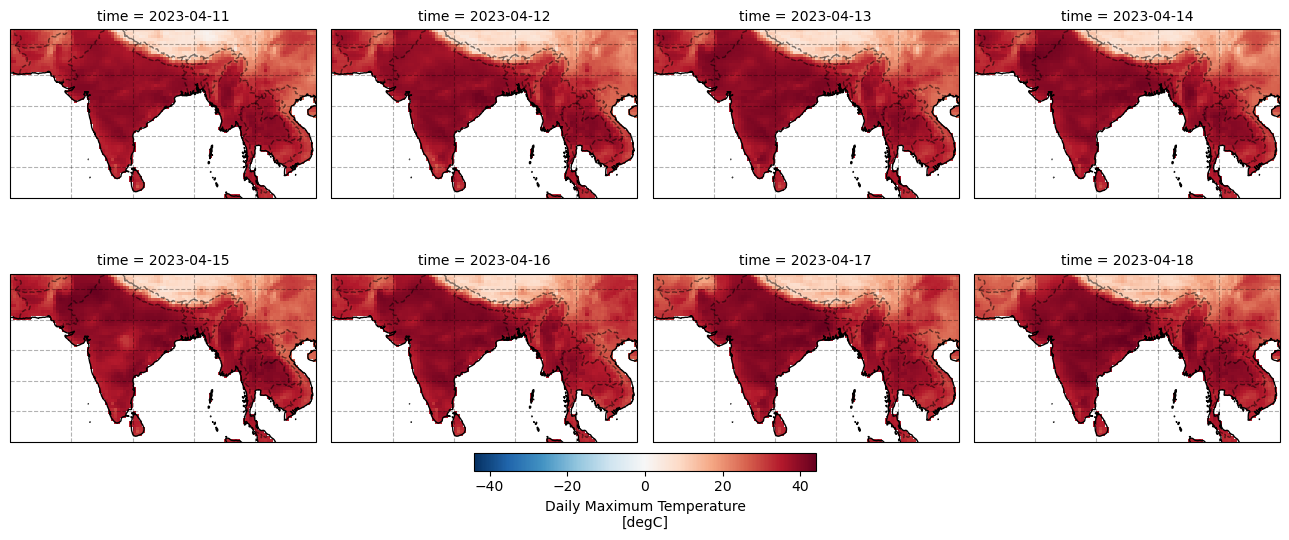

In [59]:
cpc.sel(time = slice("2023-04-11", None)).plot(col = "time", col_wrap = 4, subplot_kws = {"projection" : cartopy.crs.PlateCarree(), "extent" : (60,110,5,30)},
                                               cbar_kwargs = {"location" : "bottom", "pad" : 0.02, "fraction" : 0.03, "shrink" : 0.9})

axs = plt.gcf().axes
for ax in axs[:-1]:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
    ax.gridlines(color = "k", ls = "--", alpha = 0.3)
    

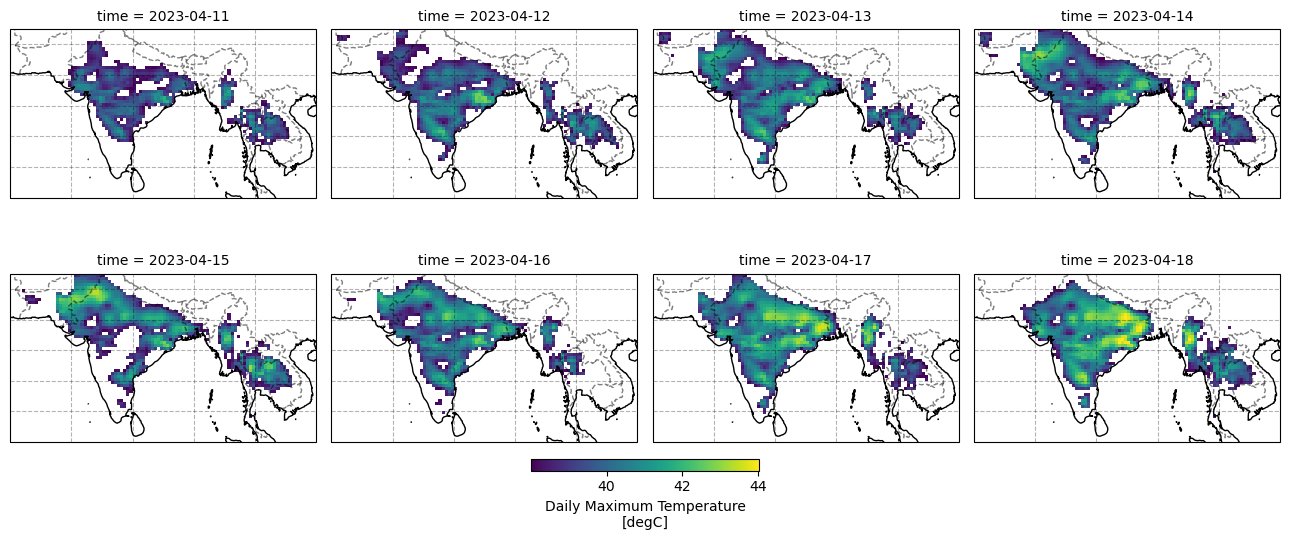

In [60]:
cpc.where(cpc > 38).sel(time = slice("2023-04-11", None)).plot(col = "time", col_wrap = 4, subplot_kws = {"projection" : cartopy.crs.PlateCarree(), "extent" : (60,110,5,30)},
                                               cbar_kwargs = {"location" : "bottom", "pad" : 0.03, "fraction" : 0.02, "shrink" : 0.9})
axs = plt.gcf().axes
for ax in axs[:-1]:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
    ax.gridlines(color = "k", ls = "--", alpha = 0.3)